In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Path of train and test data
train_dir = "../path_to_directory/seg_train/"
test_dir = "../path_to_directory/seg_test/"

# Data configs
batch_size = 32
img_height = 150
img_width = 150

# Load train data
train_ds = tf.keras.utils.image_dataset_from_directory(
	train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load test data
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


# Training the MASTER Model - using Transfer Learning
# Here we are using ImageNet pre-trained model weights
base_model = keras.applications.ResNet152(
		weights='imagenet',  # Load weights pre-trained on ImageNet.
		input_shape=(img_height, img_width, 3),
		include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False
inputs = keras.Input(shape=(img_height, img_width, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(6)(x)
model = keras.Model(inputs, outputs)
model.summary()
model.compile(
		optimizer=keras.optimizers.Adam(),
		loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
		metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs)

# Generate results on test data
results = model.evaluate(test_ds)
print(f"Test accuracy with trained teacher model:{results[1]*100 :.2f} %")

/Users/sachinkeshav/miniconda3/bin/python


Given Problem statement requires to train a smaller model (student model) based on the learning of a larger model (teacher/master model) 

Given master model is ResNet152 -> with 152 hidden layers
For a smaller model I will be using Resnet50 -> smaller model with 50 hidden layers (similary models with less layers like resnet 34, resnet 18 or any otehr custom models can be used as well

# Approach
Following steps will be done:
1. Dataset Preparation (data loading and visualization)
2. Model Loading and creation of distllation model
3. Defing model distillation Techniques, loss functions 
4. Model Training and Model Evaluation 

In [73]:
# !pip install torch
# !pip install torchvision

In [13]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision

# Step 1: Data Preparation

In [11]:
# Path of train and test data
train_dir = "./seg_train/"
test_dir = "./seg_test/"

# Data configs
batch_size = 32
img_height = 150
img_width = 150

In [12]:
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor()
])
train_dataset = datasets.ImageFolder(root = train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.ImageFolder(root = test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

class_names = train_dataset.classes
print("Classes: ", class_names)

Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


- Data Visualization

In [61]:
print("Train images: ",len(train_loader))
print("Test images: ",len(test_loader))

Train images:  439
Test images:  94


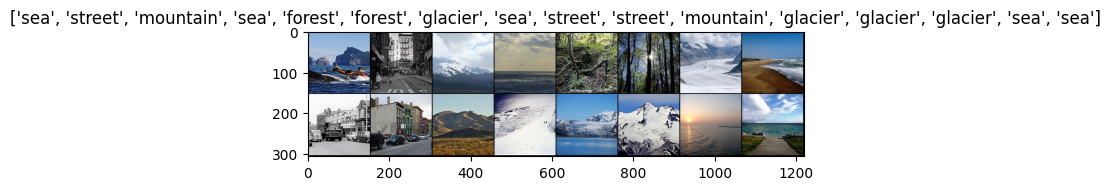

In [15]:
def imshow(image, title):
    img = image.numpy().transpose((1,2,0))
    plt.imshow(img)
    plt.title(title)
    
images, classes = next(iter(train_loader))
output = torchvision.utils.make_grid(images[:16])
imshow(output, title = [class_names[x] for x in classes[:16]])

# Step 2: Model Loading

In [16]:
from torchvision import models

In [19]:
torch.cuda.is_available()

False

In [48]:
device = torch.device("mps") #other option is "cpu" as this is a M1 chip mac

teacher_base_model = models.resnet152(pretrained=True)
student_base_model = models.resnet50(pretrained=True)

/Users/sachinkeshav/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sachinkeshav/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/sachinkeshav/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `wei

In [50]:
# x = keras.layers.GlobalAveragePooling2D()(x)
# # A Dense classifier with a single unit (binary classification)
# outputs = keras.layers.Dense(6)(x)
class CustomModel(nn.Module):
    def __init__(self, base_model):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(base_model.fc.in_features, 6)
    
    def forward(self, x):
        x = self.base_model(x)
        x = x.unsqueeze(1)
        x = self.pool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x
    
teacher_model = CustomModel(teacher_base_model)
teacher_model.to(device)
student_model = CustomModel(student_base_model)
student_model.to(device)


CustomModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

# Step3: Defining loss functions, and model distillation techniques

model distillation:
1. Soft distillation or based on output 
    - two loss functions are used 
     i. model output vs ground truth
     ii. model output vs teacher model output
     
2. Relation knowledge distillation 
    - interim layers of the student model are optimized using the master model output as well
    - attention layers of the Master Model can be used to optimize the attention layer of the Student model also know as (Attention Transfer Loss )
    - FitNets

In [29]:
class Distillation(nn.Module):
    def __init__(self, teacher, student):
        super(Distillation, self).__init__()
        self.teacher = teacher
        self.student = student
    
    def forward(self, x):
        teacher_outputs = self.teacher(x)
        student_outputs = self.student(x)
        return teacher_outputs, student_outputs
    

In [69]:
distiller_main = Distillation(teacher_model, student_model)
distiller = Distillation(teacher_base_model, student_base_model)

In [52]:
import torch.optim as optim

In [55]:
#assigning only student models weights for optimization
optimizer = optim.Adam(student_model.parameters())

student_loss_fn = nn.CrossEntropyLoss()
distillation_loss = nn.KLDivLoss(reduction='batchmean')

#alph -> how much the student vs Master final layer output loss should afftect the training process for otimization
alpha = 0.05

#temperature -> using temperature to set a soft output loss for the output layers
temperature = 40

total_epochs = 10

In [68]:
#METHOD 2 Fit net loss 


class CustomFitnetLoss(nn.Module):
    def __init__(self):
        super(CustomFitnetLoss, self).__init__()
    
    def forward(self, student_mid_layer_outputs, teacher_mid_layer_outputs):
        loss = F.mse_loss(student_mid_layer_outputs, teacher_mid_layer_outputs) 
        #other loss like mae can also be used and checked
        return loss

mid_layer_distill_loss = CustomFitnetLoss()
# as the custom loss requires mid layer outputs, Custom distillation object 
# needs to be created in order to pass the loss function

class ModifiedResNet(nn.Module):
    def __init__(self, original_model, layer_index):
        super(ModifiedResNet, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:layer_index])
        self.rest = nn.Sequential(*list(original_model.children())[layer_index:-1])
        # Similarly output of customized layers can be used for comaprison
        self.final_fc = original_model.fc
        
    def forward(self, x):
        x = self.features(x)
        mid_output = x.clone()
        x = self.rest(x)
        final_output = self.final_fc(x)
        return mid_output, final_output
    
    def get_intermediate_and_final_output(self,x):
        return self.forward
    

class MidLayerDistillation(nn.Module):
    def __init__(self, teacher, student):
        super(MidLayerDistillation, self).__init__()
        self.teacher = teacher
        self.student = student
        
    def forward(self, x):
        student_mid_output, student_final_output = self.student.get_intermediate_and_final_output(x)
        teacher_mid_output, teacher_final_output = self.teacher.get_intermediate_and_final_output(x)
        return student_mid_output, student_final_output, teacher_mid_output, teacher_final_output
        
student_model_with_mid_layer_output = ModifiedResNet(student_base_model, 7) #using random layer for now
teacher_model_with_mid_layer_output = ModifiedResNet(teacher_base_model, 7) #using random layer for now

distiller_with_mid_layer_output = MidLayerDistillation(student_model_with_mid_layer_output,
                                                      teacher_model_with_mid_layer_output)

# Step 4: Model Training

In [44]:
from tqdm import tqdm
import torch.nn.functional as F

In [56]:
def train(distiller, dataloader, optimizer, alpha, temperature, epoch, num_epochs=total_epochs, mid_layer_distill=False):
    distiller.student.train()
    running_loss = 0.00
    loop = tqdm(dataloader, leave = True)
    for data, target in loop:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        if mid_layer_distill == True:
            student_mid_output, student_final_output, teacher_mid_output, teacher_final_output = distiller_with_mid_layer_output(data)
            distill_loss = mid_layer_distill_loss(student_mid_output, teacher_mid_output)
        else:
            student_output, teacher_output = distiller(data)
            student_loss = student_loss_fn(student_output, target)

            distil_loss = distillation_loss(
            F.log_softmax(student_output / temperature, dim=1), F.softmax(teacher_output/temperature , dim=1))

        loss = alpha*student_loss + (1-alpha)*distil_loss
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

        running_loss += loss.item()
    
    average_loss = running_loss/len(dataloader)
    
    return average_loss

In [38]:
def evaluate(distiller, dataloader):
    distiller.student.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            stu_out, tea_out = distiller(data)
            _, predicted = torch.max(stu_out, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100*correct/total
    return accuracy

In [77]:
train_losses = []
test_accuracies = []

for epoch in range(total_epochs):
    train_loss = train(distiller, train_loader, optimizer, alpha, temperature, epoch)
    print(f"Train Loss for epoch:{epoch} = {train_loss}")
    train_losses.append(train_loass)
    
    test_accuracy = evaluate(distiller,test_loader)
    print(f"Test Accuracy for Epoch: {epoch} = {test_accuracy}")
    
    test_accuracies.append(test_accuracy)

In [76]:
train_losses = []
test_accuracies = []

for epoch in range(total_epochs):
    train_loss = train(distiller_with_mid_layer_output, train_loader, optimizer, alpha, temperature, 
                       epoch, mid_layer_distill=True)
    print(f"Train Loss for epoch:{epoch} = {train_loss}")
    train_losses.append(train_loass)
    
    test_accuracy = evaluate(distiller_with_mid_layer_output,test_loader)
    print(f"Test Accuracy for Epoch: {epoch} = {test_accuracy}")
    
    test_accuracies.append(test_accuracy)

Plotting the Accuracy scores

In [72]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, total_epochs+1), train_losses, label = 'Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1, total_epochs+1), test_accuracies, label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy Over Time')
plt.legend()